In [1]:
# This code is based on
# https://github.com/hunkim/DeepRL-Agents

import gym
from gym.envs.registration import register
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# From http://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
# default value = 0  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   

# import tensorflow as tf

# 예전 소스 실행을 위한 설정
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# 정상적인 경우를 확인하기 위해서는 is_slippery를 False로 하고 확인해야 함
# 즉 지시하는 방향으로 정상적으로 움직임
# is_slippery를 True일 경우 정상적으로 움직이지 않음

# is_slippery가 False이면 않미끄러짐, True이면 미끄러짐
register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': True}
)

env = gym.make('FrozenLake-v3')

# Input and output size based on the Env
input_size = env.observation_space.n;
output_size = env.action_space.n;
learning_rate = 0.1

# Set Q-learning parameters
dis = .99
num_episodes = 2000


def one_hot(x):
    return np.identity(16)[x:x+1]

--- 71.2758059501648 seconds ---
Success rate: 0.524


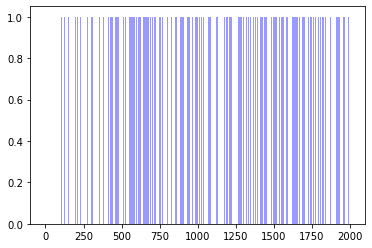

In [3]:
# These lines establish the feed-forward part of the network used to choose actions
# 1 x 16
X = tf.placeholder(shape=[1, input_size], dtype=tf.float32)              # state input

# 16 x 4
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))   # weight

# Out Q prediction  vector(1 x 16) x matrix(16 x 4) = vector(1 x 4)
# Qpred는 수식
Qpred = tf.matmul(X, W)

# 1 x 4
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)    # Y label

# loss는 수식
loss = tf.reduce_sum(tf.square(Y-Qpred))

# train은 수식
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

# create lists to contain total rewards and steps per episode
rList = []

start_time = time.time()

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        # s는 맵상에서 현재 위치
        s = env.reset()
        
        #현재 위치 확인        
        #env.render()
        
        e = 1. / ((i / 50) + 10)
        rAll = 0
        done = False
        local_loss = []

        # The Q-Table learning algorithm
        while not done:
            # Choose an action by greedly (with a chance of random action)
            # from the Q-network 
            # Qs는 vector(1 x 4)
            Qs = sess.run(Qpred, feed_dict={X: one_hot(s)})
            
            #print('s => ', s)
            #print('one_hot(s) => ', one_hot(s))
            #print('Qs => ', Qs)
            
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)

            # 최적의 경로를 찾기 위해서 np.argmax(Qs) 사용
            #a = np.argmax(Qs)
            #print('a => ', a)    
            
            # Get new state and reward from environment
            s1, reward, done, _ = env.step(a)
            
            #현재 위치 확인
            #env.render()

            if done:
                # Update Q, and no Qs+1, since it's a termial state
                Qs[0, a] = reward
            else:
                # Obtain the Q_s` values by feeding the new state through our network
                Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1)})
                
                # Update Q, Qs는 정답(label)
                Qs[0, a] = reward + dis*np.max(Qs1)

            #print('----------------------------------- ')    
            # Train our network using target (Y) and predicted Q (Qpred) values
            sess.run(train, feed_dict={X: one_hot(s), Y: Qs})

            rAll += reward
            s = s1
        rList.append(rAll)
        #print('------------------------------------------------------------------ ')    

print("--- %s seconds ---" % (time.time() - start_time))

print("Success rate: " + str(sum(rList) / num_episodes))
#plt.bar(range(len(rList)), rList, color="blue")
plt.bar(range(len(rList)), rList, color='b', alpha=0.4)
plt.show()